In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-temperature-of-major-cities/city_temperature.csv


### make a prediction for all turkey's cities, make a time graph for all cities show how temperatures rise. do it for the all world, and make predictions with lstm

# Loading and Tidying Data

In [3]:
data = pd.read_csv("/kaggle/input/daily-temperature-of-major-cities/city_temperature.csv", low_memory = False)

In [3]:
data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB


In [5]:
data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Month,Day,Year,AvgTemperature
count,2.90633e+06,2.90633e+06,2.90633e+06,2.90633e+06
mean,6.46916,15.7168,2006.62,56.0049
std,3.45649,8.80053,23.3823,32.1236
min,1,0,200,-99
25%,3,8,2001,45.8
50%,6,16,2007,62.5
75%,9,23,2013,75.5
max,12,31,2020,110


* so we are going to do a world base analysis not us. thats why lets convert avg temperatures to metric system 

In [4]:
def to_celcius(x):
    x = (x - 32) / 1.8
    return round(x,2)
data["AvgTemperature"] = data["AvgTemperature"].apply(to_celcius)

In [7]:
data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Month,Day,Year,AvgTemperature
count,2.90633e+06,2.90633e+06,2.90633e+06,2.90633e+06
mean,6.46916,15.7168,2006.62,13.336
std,3.45649,8.80053,23.3823,17.8467
min,1,0,200,-72.78
25%,3,8,2001,7.67
50%,6,16,2007,16.94
75%,9,23,2013,24.17
max,12,31,2020,43.33


* we need to convert seperate month day year columns to datetime

In [5]:
data["Date"] = pd.to_datetime(data[["Day","Month","Year"]],errors="coerce")
data.drop(columns = ["Month", "Day", "Year"], axis=1, inplace = True)

In [9]:
data[data["Date"].isnull()]

,Region,Country,State,City,AvgTemperature,Date
58204,Africa,Ethiopia,NaN,Addis Ababa,-72.78,NaT
58205,Africa,Ethiopia,NaN,Addis Ababa,-72.78,NaT
58206,Africa,Ethiopia,NaN,Addis Ababa,-72.78,NaT
82774,Africa,Guinea,NaN,Conakry,-72.78,NaT
85697,Africa,Guinea,NaN,Conakry,-72.78,NaT
92041,Africa,Guinea-Bissau,NaN,Bissau,-72.78,NaT
112002,Africa,Kenya,NaN,Nairobi,-72.78,NaT
112003,Africa,Kenya,NaN,Nairobi,-72.78,NaT
112004,Africa,Kenya,NaN,Nairobi,-72.78,NaT
146077,Africa,Malawi,NaN,Lilongwe,-72.78,NaT


* these values are needs to be dropped because temperature values are wrong and date values are missing. so lets drop them. 
* after i dropped the nan values in the date column i realized that missing values in the temperature column filled with -72.78. so i went back and dropped all the -72.78 values. this is the last version of the code.

In [6]:
idx = data[data["AvgTemperature"] == -72.78].index
data.drop(index = idx, axis = 0, inplace = True)
data.reset_index(drop = True, inplace = True)

In [11]:
data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,AvgTemperature
count,2.82666e+06
mean,15.7633
std,10.6097
min,-45.56
25%,8.56
50%,17.39
75%,24.39
max,43.33


* now our min values for average temperature makes sense, lets look few rows and check it ourselves.

In [12]:
data["AvgTemperature"].sort_values().head(10)

1424157   -45.56
1423828   -45.06
1428562   -44.28
1424158   -43.83
1423072   -43.44
1423827   -43.28
1426372   -43.22
1424156   -43.22
1424160   -43.11
1424159   -42.61
Name: AvgTemperature, dtype: float64

In [13]:
data.iloc[[1424157]]

,Region,Country,State,City,AvgTemperature,Date
1424157,North America,US,Alaska,Fairbanks,-45.56,1999-12-31


* in 1999 and in alaska and in the new years eve. that makes sense. lets look another one

In [14]:
data.iloc[[1428562]]

,Region,Country,State,City,AvgTemperature,Date
1428562,North America,US,Alaska,Fairbanks,-44.28,2012-01-29


* alaska again but this time in 2012, so now we can visualize our data.

# Exploratory Data Analysis

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
sns.set()

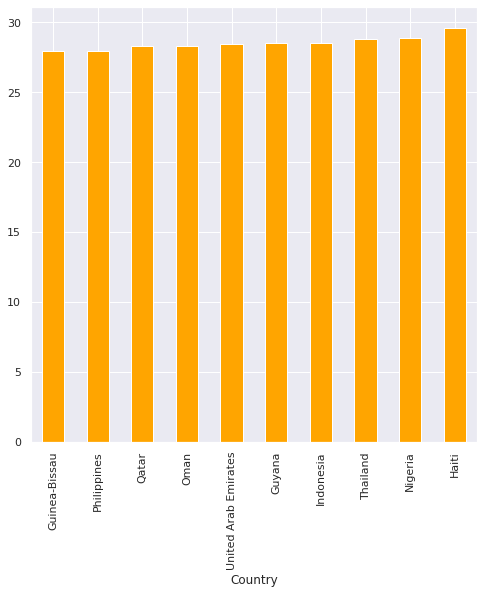

In [17]:
f, ax = plt.subplots(figsize= (8,8))
data.groupby("Country")["AvgTemperature"].mean().sort_values().tail(10).plot(kind = "bar",color="orange",ax=ax)
plt.show()

* 10 hottest country in the world. Actually i was surprised when i see haiti is the first. i was expecting a middle east country.

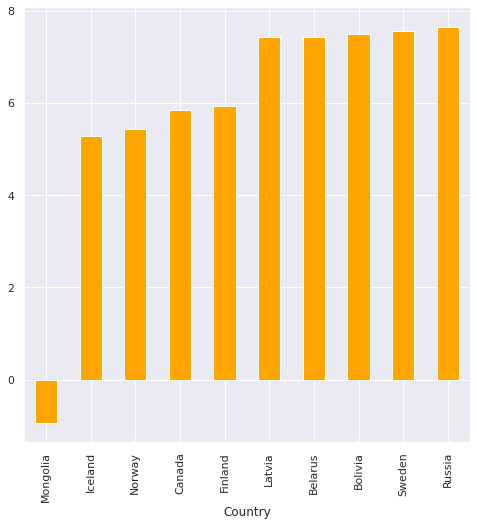

In [18]:
f, ax = plt.subplots(figsize= (8,8))
data.groupby("Country")["AvgTemperature"].mean().sort_values().head(10).plot(kind = "bar",color="orange",ax=ax)
plt.show()

* One more time, i surprised to see the lead. But when i searched in google i saw that most of the nights in Mongolia in winter is -40°C.

In [8]:
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month

In [9]:
data["Year-Month"] = data["Year"].astype(str) + "-" + data["Month"].astype(str)

In [21]:
data.head()

,Region,Country,State,City,AvgTemperature,Date,Year,Month,Year-Month
0,Africa,Algeria,NaN,Algiers,17.89,1995-01-01,1995,1,1995-1
1,Africa,Algeria,NaN,Algiers,9.67,1995-01-02,1995,1,1995-1
2,Africa,Algeria,NaN,Algiers,9.33,1995-01-03,1995,1,1995-1
3,Africa,Algeria,NaN,Algiers,8.00,1995-01-04,1995,1,1995-1
4,Africa,Algeria,NaN,Algiers,8.83,1995-01-05,1995,1,1995-1


In [22]:
data.groupby("Region")["AvgTemperature"].max()

Region
Africa                               39.33
Asia                                 39.83
Australia/South Pacific              36.00
Europe                               39.17
Middle East                          43.33
North America                        42.06
South/Central America & Carribean    36.33
Name: AvgTemperature, dtype: float64

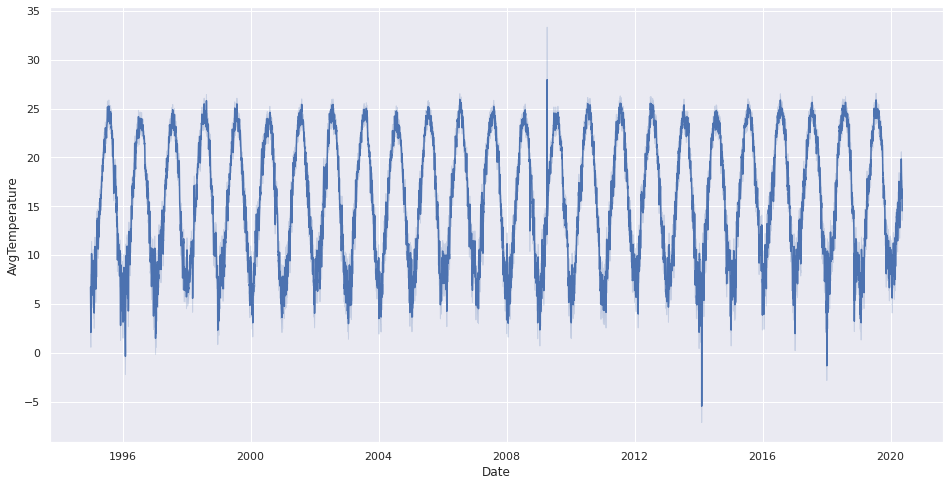

In [23]:
f, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x = "Date", y = "AvgTemperature",data=data,ax=ax)

* There is not much to understand by just looking here..

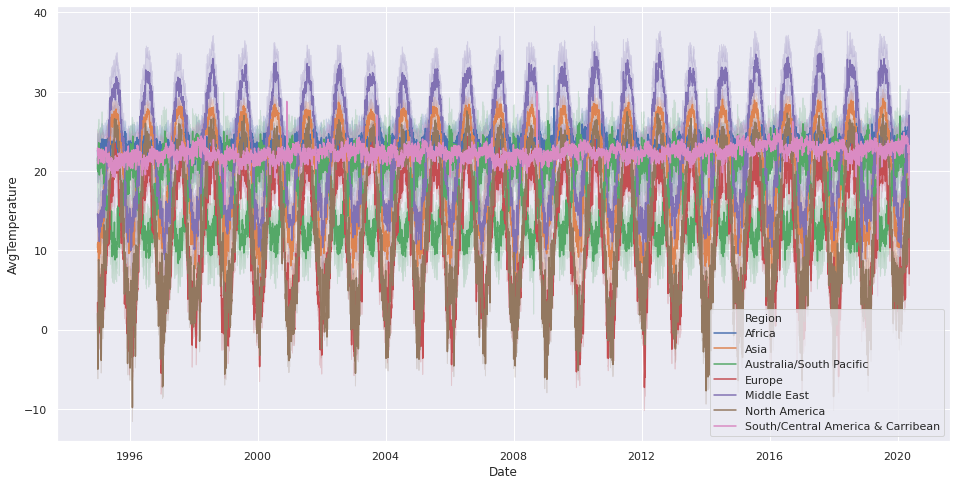

In [24]:
f, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x = "Date", y = "AvgTemperature",hue="Region",data=data,ax=ax)

* We can see that temperatures are mostly same in Sout/Central America
* And highest temperatures are in Middle East.

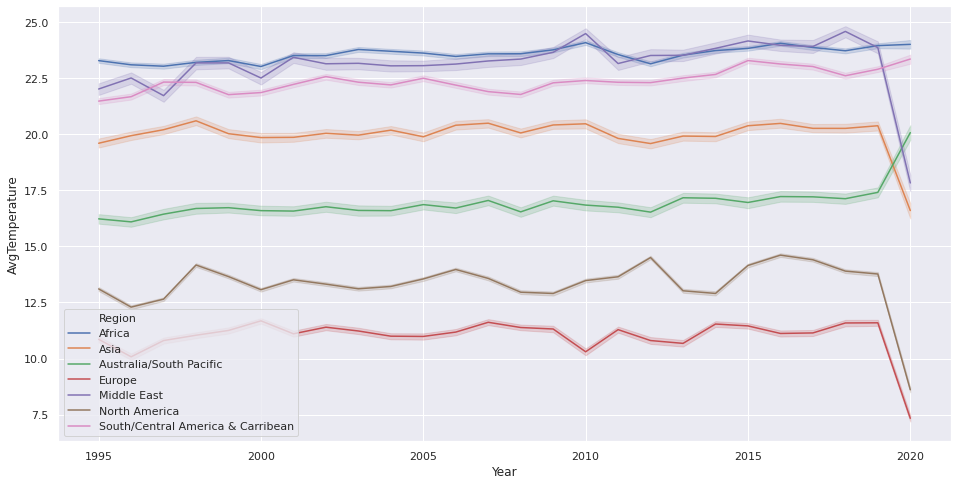

In [25]:
f, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x = "Year" , y = "AvgTemperature",hue="Region",data=data,ax = ax)
plt.show()

* We can see that temperatures fall highly in 2020. Except Australia :(
* And we can see that temperatures are rising very slowly throughout the years.

In [9]:
slice1 = data[data["Region"] == "Europe"]

In [27]:
slice1.head()

,Region,Country,State,City,AvgTemperature,Date,Year,Month,Year-Month
582291,Europe,Albania,NaN,Tirana,13.00,1997-04-21,1997,4,1997-4
582292,Europe,Albania,NaN,Tirana,13.78,1997-04-25,1997,4,1997-4
582293,Europe,Albania,NaN,Tirana,16.39,1997-04-26,1997,4,1997-4
582294,Europe,Albania,NaN,Tirana,16.00,1997-04-27,1997,4,1997-4
582295,Europe,Albania,NaN,Tirana,14.00,1997-04-28,1997,4,1997-4


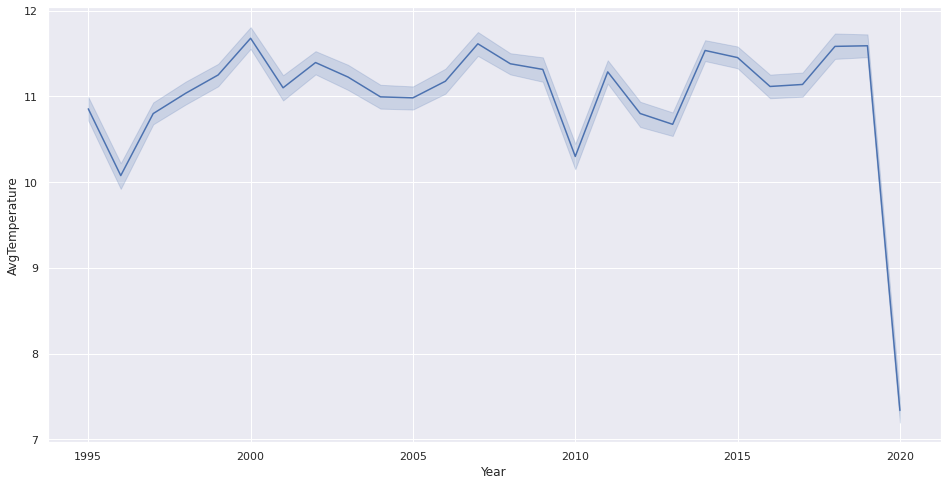

In [28]:
f, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x = "Year" , y = "AvgTemperature",data=slice1,ax = ax)
plt.show()

* We can see that after a rise temperatures fall hardly in 2020. The reason of this because it was the hottest January in Europe since 2007.
* Lets check the data and see if its true.

In [29]:
onlyjanuary=slice1[slice1["Month"] == 1]

In [30]:
slice1[slice1["Year-Month"] == "2020-1"].sort_values(by = "AvgTemperature", ascending = False).head(10)

,Region,Country,State,City,AvgTemperature,Date,Year,Month,Year-Month
867825,Europe,Spain,NaN,Bilbao,16.89,2020-01-31,2020,1,2020-1
867810,Europe,Spain,NaN,Bilbao,16.78,2020-01-16,2020,1,2020-1
867824,Europe,Spain,NaN,Bilbao,16.50,2020-01-30,2020,1,2020-1
815195,Europe,Portugal,NaN,Lisbon,15.78,2020-01-15,2020,1,2020-1
815198,Europe,Portugal,NaN,Lisbon,15.00,2020-01-18,2020,1,2020-1
815208,Europe,Portugal,NaN,Lisbon,14.83,2020-01-28,2020,1,2020-1
815196,Europe,Portugal,NaN,Lisbon,14.72,2020-01-16,2020,1,2020-1
867821,Europe,Spain,NaN,Bilbao,14.67,2020-01-27,2020,1,2020-1
867809,Europe,Spain,NaN,Bilbao,14.50,2020-01-15,2020,1,2020-1
815209,Europe,Portugal,NaN,Lisbon,14.39,2020-01-29,2020,1,2020-1


In [31]:
slice1[slice1["Year-Month"] == "2007-1"].sort_values(by = "AvgTemperature", ascending = False).head(10)

,Region,Country,State,City,AvgTemperature,Date,Year,Month,Year-Month
863082,Europe,Spain,NaN,Bilbao,16.83,2007-01-18,2007,1,2007-1
711495,Europe,Greece,NaN,Athens,16.06,2007-01-27,2007,1,2007-1
711494,Europe,Greece,NaN,Athens,15.94,2007-01-26,2007,1,2007-1
711493,Europe,Greece,NaN,Athens,15.50,2007-01-25,2007,1,2007-1
711488,Europe,Greece,NaN,Athens,15.33,2007-01-20,2007,1,2007-1
711492,Europe,Greece,NaN,Athens,15.33,2007-01-24,2007,1,2007-1
680601,Europe,France,NaN,Bordeaux,14.61,2007-01-18,2007,1,2007-1
863073,Europe,Spain,NaN,Bilbao,14.56,2007-01-09,2007,1,2007-1
863065,Europe,Spain,NaN,Bilbao,14.44,2007-01-01,2007,1,2007-1
671383,Europe,France,NaN,Paris,14.39,2007-01-18,2007,1,2007-1


* We can see that temperatures are really close to each other, but 2020 is a little bit higher. That makes sense.
* Now lets look at another years temperatures.

In [32]:
slice1[slice1["Year-Month"] == "2016-1"].sort_values(by = "AvgTemperature", ascending = False).head(15)

,Region,Country,State,City,AvgTemperature,Date,Year,Month,Year-Month
857116,Europe,Spain,NaN,Barcelona,16.78,2016-01-08,2016,1,2016-1
866370,Europe,Spain,NaN,Bilbao,16.17,2016-01-25,2016,1,2016-1
857119,Europe,Spain,NaN,Barcelona,16.17,2016-01-11,2016,1,2016-1
758054,Europe,Italy,NaN,Rome,15.83,2016-01-10,2016,1,2016-1
813737,Europe,Portugal,NaN,Lisbon,15.72,2016-01-04,2016,1,2016-1
857115,Europe,Spain,NaN,Barcelona,15.67,2016-01-07,2016,1,2016-1
857117,Europe,Spain,NaN,Barcelona,15.61,2016-01-09,2016,1,2016-1
758055,Europe,Italy,NaN,Rome,15.61,2016-01-11,2016,1,2016-1
866369,Europe,Spain,NaN,Bilbao,15.56,2016-01-24,2016,1,2016-1
813756,Europe,Portugal,NaN,Lisbon,15.44,2016-01-23,2016,1,2016-1


* Well looks like our assumption is true. Even tho there is a peak in 2016 overall temperature is higher in both 2007 and 2020.

In [53]:
"""fig = px.bar(data, x = "AvgTemperature", y = "Region", color = "Region",animation_frame = "Year",animation_group="Region",range_x=[-40,45])
fig.show()"""

'fig = px.bar(data, x = "AvgTemperature", y = "Region", color = "Region",animation_frame = "Year",animation_group="Region",range_x=[-40,45])\nfig.show()'

* And lastly i want to look at Turkey's statistics, because i live there. :)

In [34]:
slice2 = data[data["Country"] == "Turkey"]

In [35]:
slice2.head()

,Region,Country,State,City,AvgTemperature,Date,Year,Month,Year-Month
1034867,Middle East,Turkey,NaN,Ankara,7.89,1995-01-01,1995,1,1995-1
1034868,Middle East,Turkey,NaN,Ankara,10.50,1995-01-02,1995,1,1995-1
1034869,Middle East,Turkey,NaN,Ankara,8.17,1995-01-03,1995,1,1995-1
1034870,Middle East,Turkey,NaN,Ankara,5.33,1995-01-04,1995,1,1995-1
1034871,Middle East,Turkey,NaN,Ankara,5.44,1995-01-05,1995,1,1995-1


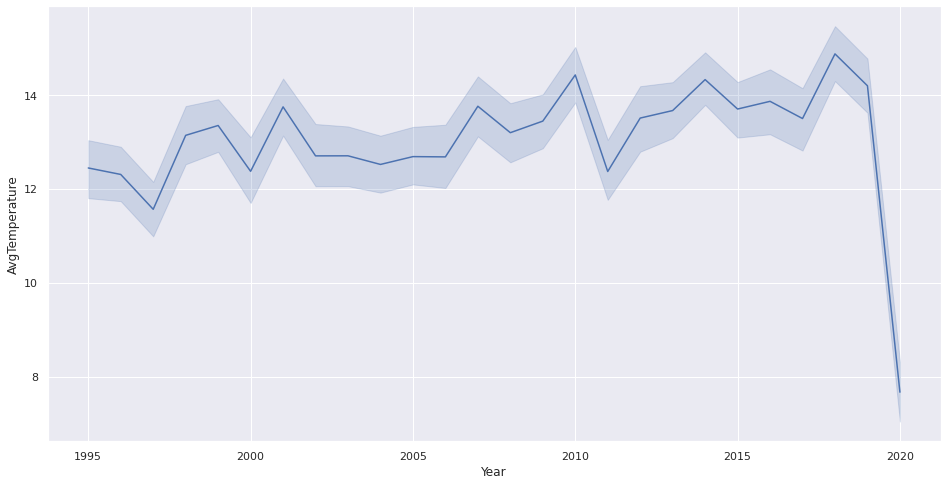

In [36]:
f, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x = "Year" , y = "AvgTemperature",data=slice2,ax = ax)
plt.show()

* Now because i wanted to look at Turkey's stats too because i live in Turkey. 
* Like all average in all over the World, temperatures fall.
* Similar to all countries we can see that temperatures rise over the years.

# Modeling

* Now we need to prepare our data to modeling. 
* I will not use state feature because many countries in the world doesnt have any state, just cities.
* I want to try LSTM to predict values but i will also use classic ML techniques to predict the temperatures. And lastly i will use ARIMA. But mainly i will focus on LSTM.
* So lets begin.

In [40]:
# Import Necessary Libraries

from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

Using TensorFlow backend.


In [10]:
data1 = data.copy(deep = True)

In [11]:
data.head()

,Region,Country,State,City,AvgTemperature,Date,Year,Month,Year-Month
0,Africa,Algeria,NaN,Algiers,17.89,1995-01-01,1995,1,1995-1
1,Africa,Algeria,NaN,Algiers,9.67,1995-01-02,1995,1,1995-1
2,Africa,Algeria,NaN,Algiers,9.33,1995-01-03,1995,1,1995-1
3,Africa,Algeria,NaN,Algiers,8.00,1995-01-04,1995,1,1995-1
4,Africa,Algeria,NaN,Algiers,8.83,1995-01-05,1995,1,1995-1


In [12]:
data.City.value_counts().head(10)

Washington       18498
Washington DC    18498
Portland         18493
Charleston       18490
Columbus         18472
Springfield      18464
Munich            9850
Oslo              9584
Fairbanks         9253
Shreveport        9253
Name: City, dtype: int64

In [13]:
data1.drop(["State","Year","Month","Year-Month"],axis=1,inplace = True)

In [14]:
data1.head()

,Region,Country,City,AvgTemperature,Date
0,Africa,Algeria,Algiers,17.89,1995-01-01
1,Africa,Algeria,Algiers,9.67,1995-01-02
2,Africa,Algeria,Algiers,9.33,1995-01-03
3,Africa,Algeria,Algiers,8.00,1995-01-04
4,Africa,Algeria,Algiers,8.83,1995-01-05


In [15]:
dataslice1 = data1[data1["City"] == "Washington"]

In [16]:
dataslice1.head()

,Region,Country,City,AvgTemperature,Date
1592807,North America,US,Washington,4.78,1995-01-01
1592808,North America,US,Washington,4.33,1995-01-02
1592809,North America,US,Washington,-1.50,1995-01-03
1592810,North America,US,Washington,0.56,1995-01-04
1592811,North America,US,Washington,-6.17,1995-01-05


In [17]:
dataslice1.drop(["Region","Country"],axis=1,inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
dataslice1.head()

,City,AvgTemperature,Date
1592807,Washington,4.78,1995-01-01
1592808,Washington,4.33,1995-01-02
1592809,Washington,-1.50,1995-01-03
1592810,Washington,0.56,1995-01-04
1592811,Washington,-6.17,1995-01-05


In [100]:
df = dataslice1.AvgTemperature.values
df = np.reshape(df, (-1,1))
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
train_size = int(len(df) * 0.85)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size: len(df),:]

In [101]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [102]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=50, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 15692 samples, validate on 2744 samples
Epoch 1/50
15692/15692 [==============================] - 1s 77us/step - loss: 0.0173 - val_loss: 0.0077
Epoch 2/50
15692/15692 [==============================] - 1s 47us/step - loss: 0.0080 - val_loss: 0.0061
Epoch 3/50
15692/15692 [==============================] - 1s 47us/step - loss: 0.0067 - val_loss: 0.0055
Epoch 4/50
15692/15692 [==============================] - 1s 48us/step - loss: 0.0065 - val_loss: 0.0051
Epoch 5/50
15692/15692 [==============================] - 1s 48us/step - loss: 0.0066 - val_loss: 0.0050
Epoch 6/50
15692/15692 [==============================] - 1s 47us/step - loss: 0.0058 - val_loss: 0.0047
Epoch 7/50
15692/15692 [==============================] - 1s 47us/step - loss: 0.0062 - val_loss: 0.0048
Epoch 8/50
15692/15692 [==============================] - 1s 47us/step - loss: 0.0056 - val_loss: 0.0047
Epoch 9/50
15692/15692 [==============================] - 1s 47us/step - loss: 0.0057 - val_loss: 0.0046
Epoch 

In [103]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 2.099314202343088
Train Root Mean Squared Error: 2.803303281648966
Test Mean Absolute Error: 2.188149083070525
Test Root Mean Squared Error: 2.898033472895735


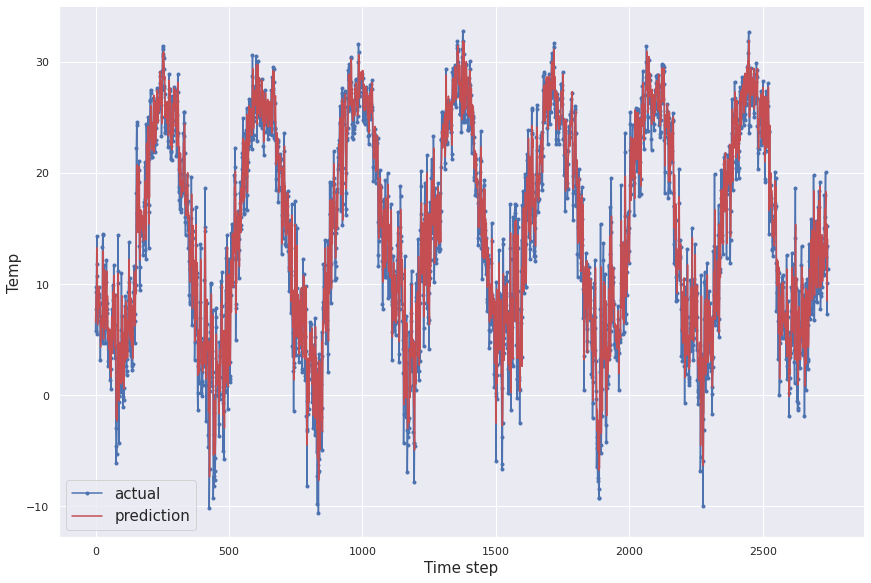

In [108]:
aa=[x for x in range(2744)]
plt.figure(figsize=(12,8))
plt.plot(aa, Y_test[0][:2744], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:2744], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
#plt.subplots_adjust(left=0.07)
plt.ylabel('Temp', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();